RAG Overview

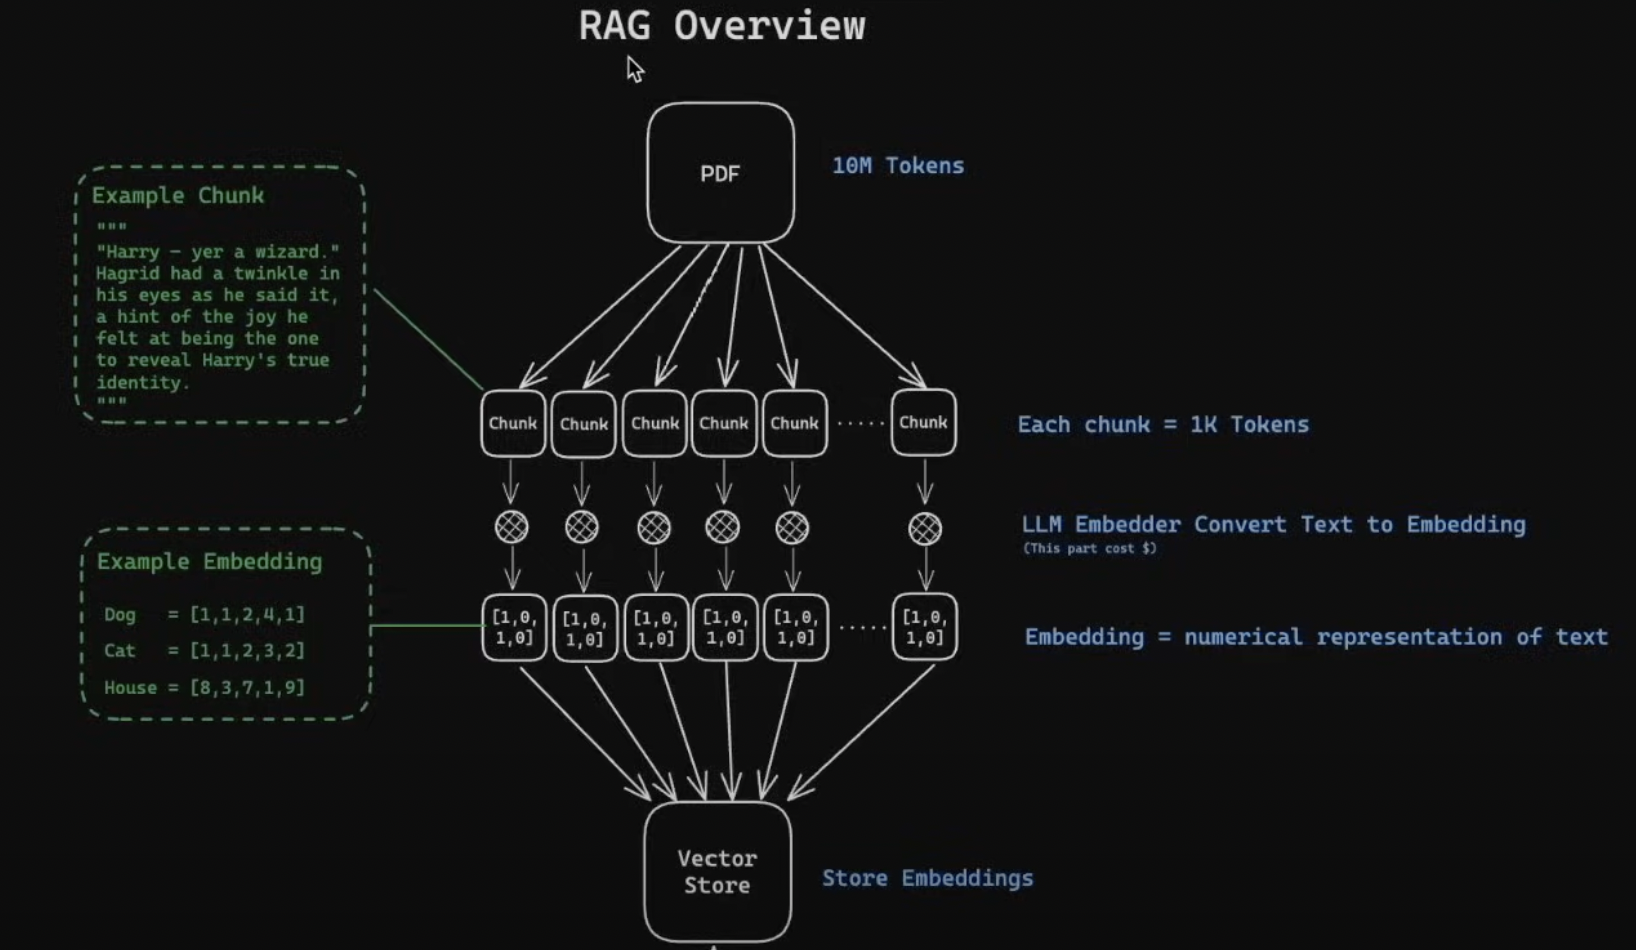
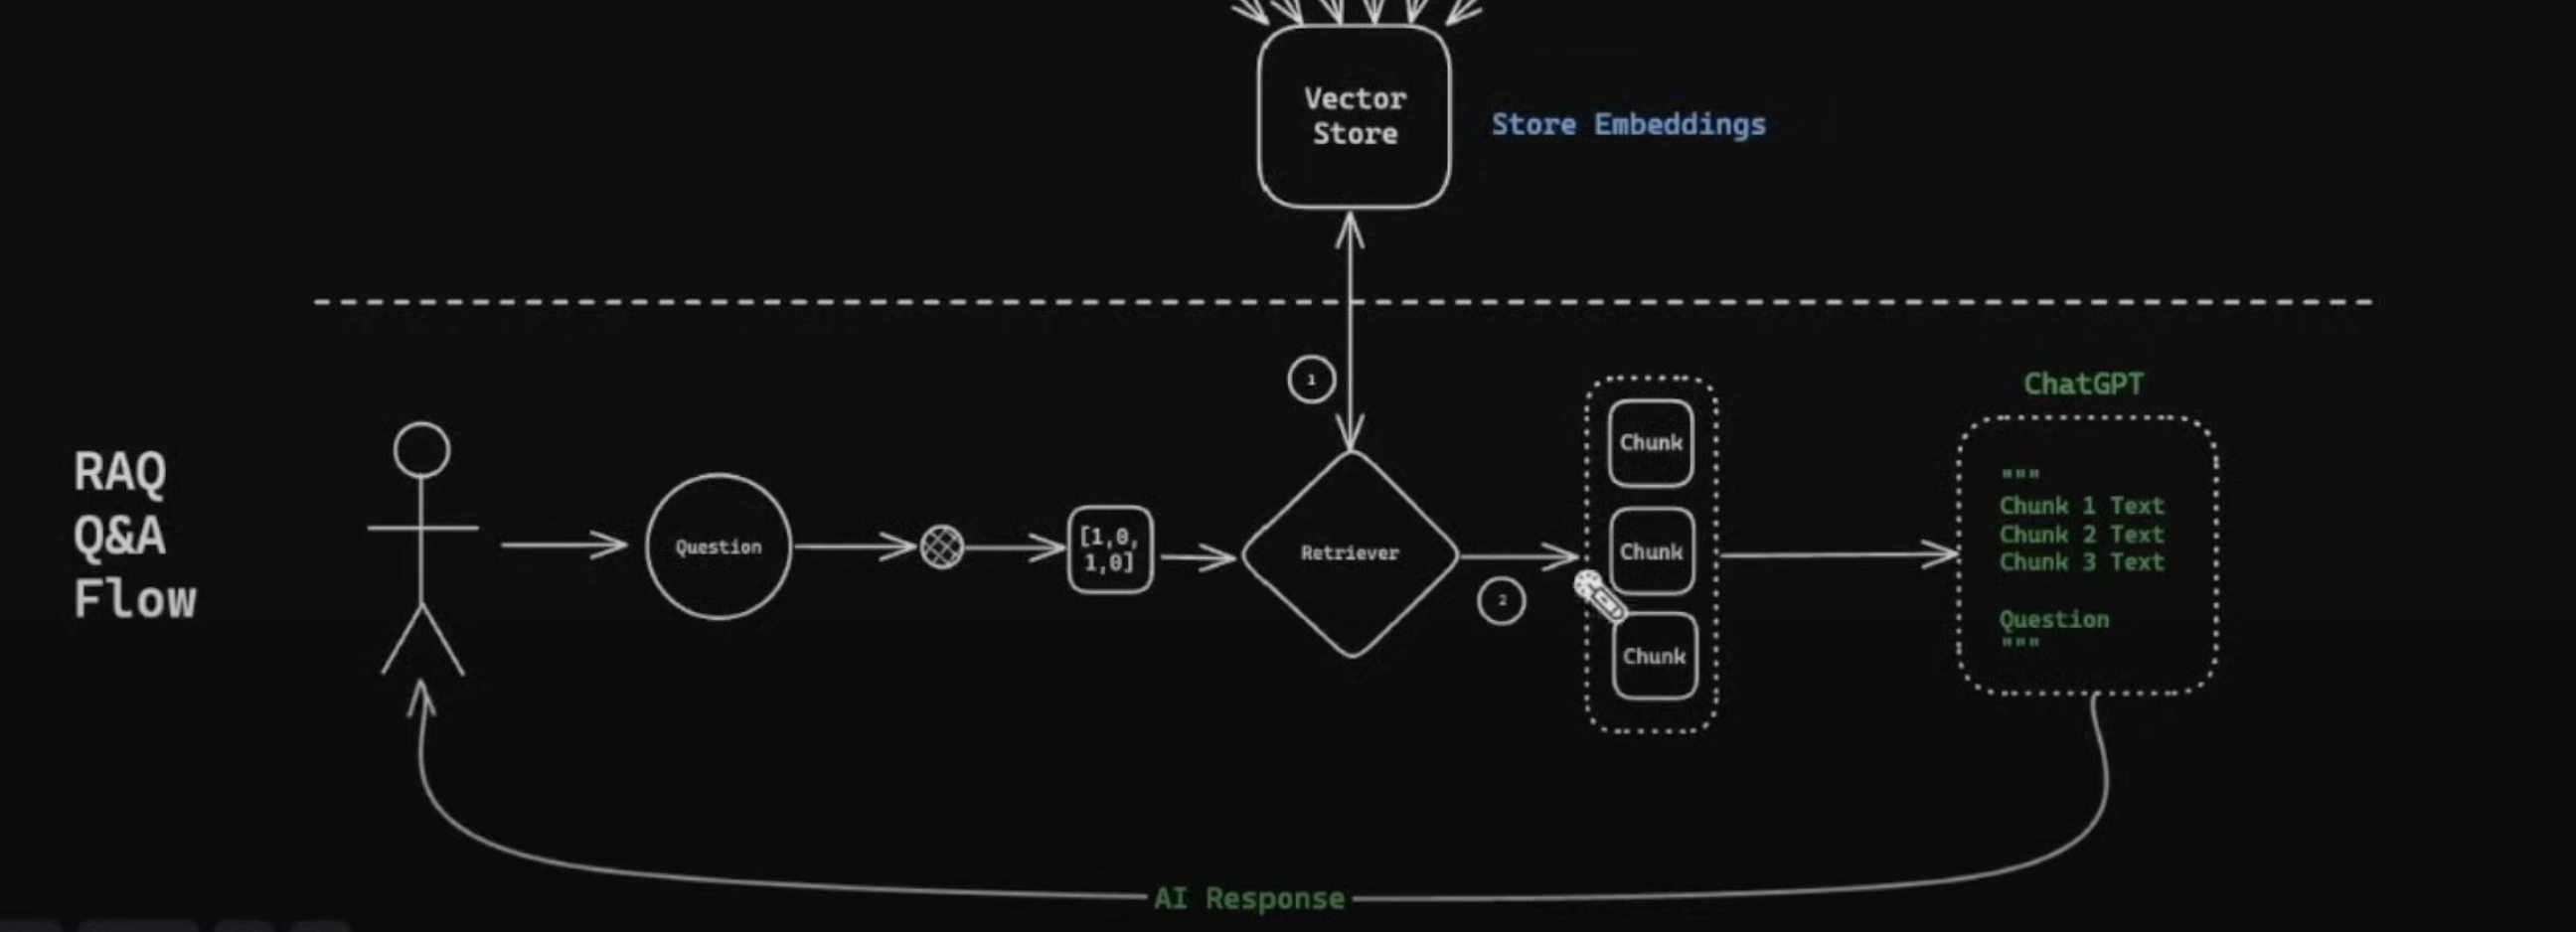


In [2]:
%pip install langchain --quiet
%pip install langchain_core --quiet
%pip install langchain_openai --quiet
%pip install langchain_community --quiet
%pip install chromadb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61

In [21]:
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
import os
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

import warnings
warnings.filterwarnings('ignore')

Setting up the directory containing the text files and the persistent directory (chromadb)

In [19]:
# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = '/content/drive/MyDrive/Colab Notebooks/Langchain'
file_path = os.path.join(current_dir, 'books',"odyssey.txt")
persistent_directory = os.path.join(current_dir, 'db','chromadb')

Steps below for setting up the Chunking, Embeddings, Vector Store:

1. Checking if the Chroma vector store already exists
2. Checking if the file exists in the file path
3. Loading the document
4. Splitting the document in chunks
5. Create Embeddings
6. Create the Vector Store and persist it

In [22]:
if not os.path.exists(persistent_directory):
  print(f"Persistent Directory does not exist. Initializing Vector Store....")
  # Ensuring the text file exists.
  if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} does not exist. Please check the file path...")

  # Read the text context from the file
  loader = TextLoader(file_path)
  documents = loader.load()

  # Split the documents in chunks
  text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
  docs = text_splitter.split_documents(documents)

  # Display information about the splitted documents
  print("\n --- DOCUMENT CHUNKS INFORMATION ---")
  print(f"Number of document chunks: {len(docs)}")
  print(f"Sample Chunk:\n {docs[0].page_content}\n")

  # Create Embeddings
  print("\n --- CREATING EMBEDDINGS ---")
  embeddings = OpenAIEmbeddings(model = "text-embedding-3-small")
  print("\n --- Embeddings created successfully ---")

  # Create the vector store
  print("\n --- CREATING VECTOR STORE ---")
  db = Chroma.from_documents(
      docs,
      embeddings,
      persist_directory=persistent_directory)
  print("\n ---Vector store created successfully ---")

else:
  print(f"Persistent Directory already exists. No need of initializing....")


Persistent Directory already exists. No need of initializing....


Loading the existing Vector Store with the Embeddings

In [23]:
embeddings = OpenAIEmbeddings(model = "text-embedding-3-small")
db = Chroma(
    persist_directory=persistent_directory,
    embedding_function=embeddings
)

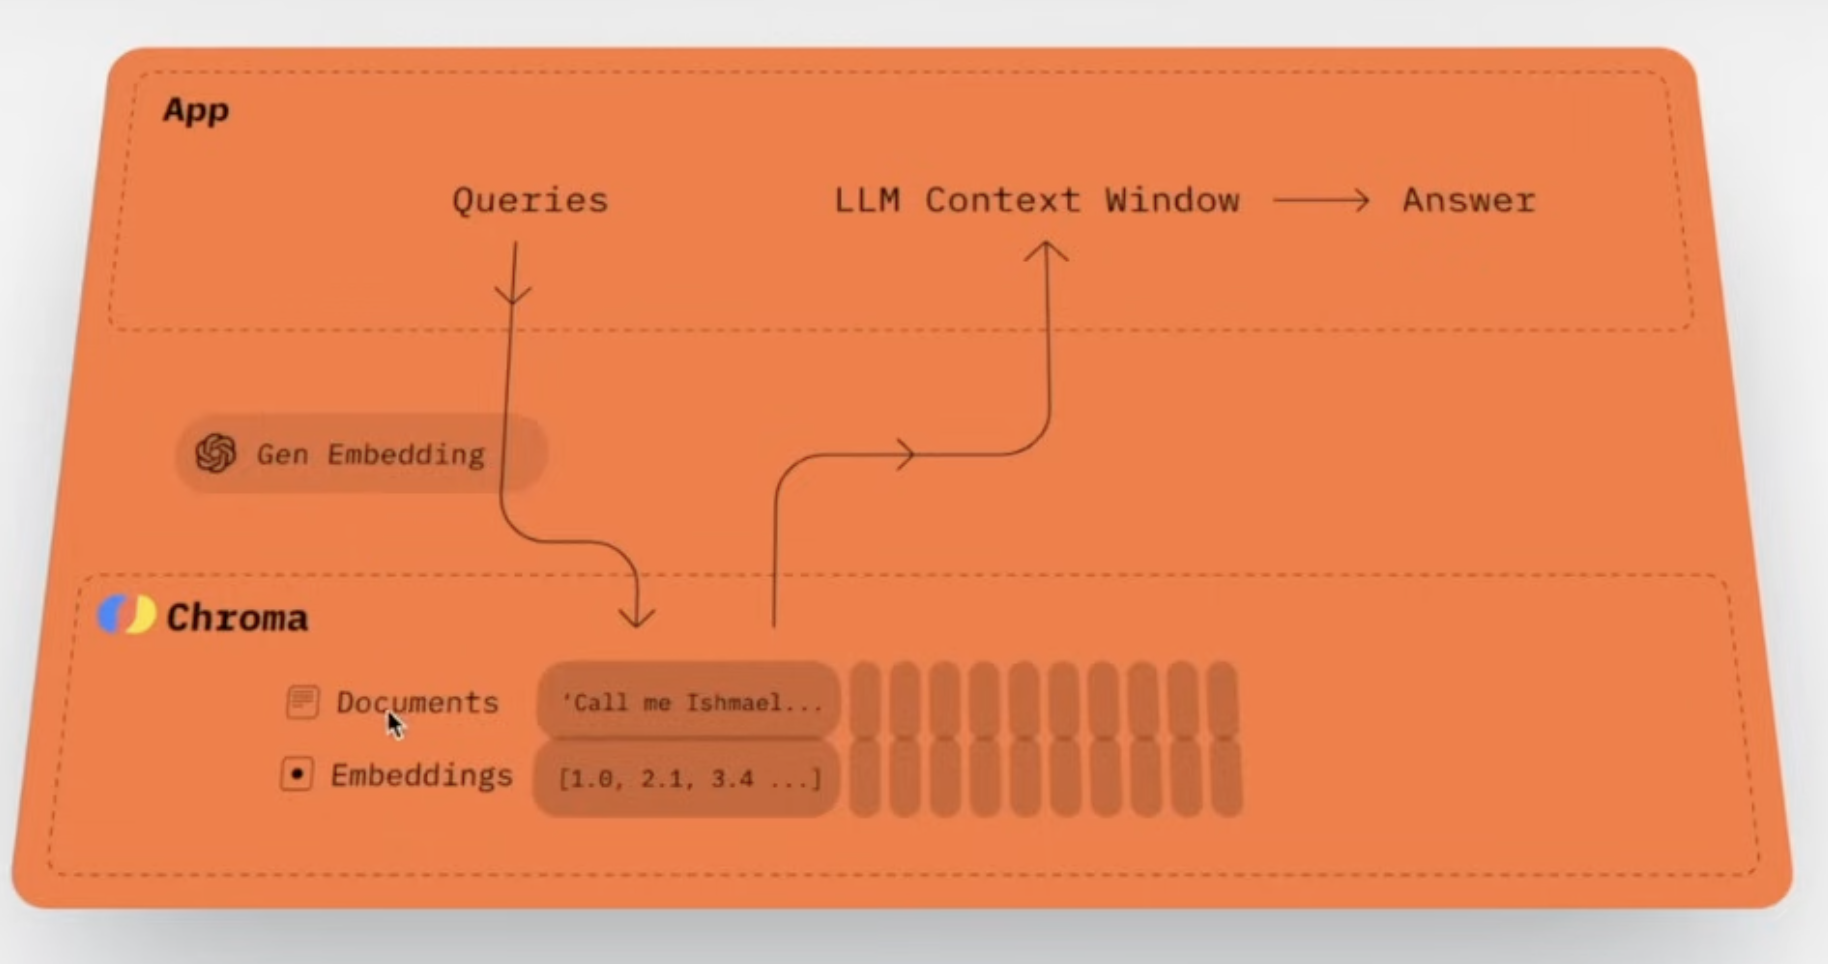

Define the User's Question

In [24]:
query = "Who is Odysseus' wife?"

Retrieve relevant documents based on the query

In [25]:
retriever = db.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 3, "score_threshold": 0.4}
)

relevant_docs = retriever.invoke(query)

Display the relevant results with metadata

In [26]:
print("\n --- Relevant Documents ---")
for i, doc in enumerate(relevant_docs):
  print(f"Document {i+1}:\n{doc.page_content}\n")
  if doc.metadata:
    print(f"Source: {doc.metadata.get('source','Unknown')}\n")


 --- Relevant Documents ---
Document 1:
“Happy Ulysses, son of Laertes,” replied the ghost of Agamemnon, “you
are indeed blessed in the possession of a wife endowed with such rare
excellence of understanding, and so faithful to her wedded lord as
Penelope the daughter of Icarius. The fame, therefore, of her virtue
shall never die, and the immortals shall compose a song that shall be
welcome to all mankind in honour of the constancy of Penelope. How far
otherwise was the wickedness of the daughter of Tyndareus who killed
her lawful husband; her song shall be hateful among men, for she has
brought disgrace on all womankind even on the good ones.”

Source: /content/drive/MyDrive/Colab Notebooks/Langchain/books/odyssey.txt

Document 2:
Then Ulysses answered, “Madam, wife of Ulysses, you need not defer your
tournament, for Ulysses will return ere ever they can string the bow,
handle it how they will, and send their arrows through the iron.”

To this Penelope said, “As long, sir, as you wil